# Practica SQL

## Set Up

In [ ]:
# install
!apt install postgresql postgresql-contrib &>log
!service postgresql start
!sudo -u postgres psql -c "CREATE USER root WITH SUPERUSER"
# set connection
%load_ext sql
%config SqlMagic.feedback=False
%config SqlMagic.autopandas=True
%sql postgresql+psycopg2://@/postgres
%sql CREATE SCHEMA IF NOT EXISTS bootcamp

In [ ]:
import pandas as pd
import sqlalchemy

engine = sqlalchemy.create_engine("postgresql+psycopg2://@/postgres")
conn = engine.connect()

akas = pd.read_csv("https://drive.google.com/uc?id=1MDgiAel34RZULi9a1WXuzGQOE9M5_aGp",nrows=200000,sep="\t")
akas.columns = [i.lower() for i in akas.columns]
crew = pd.read_csv("https://drive.google.com/uc?id=1vzlcrhm77MFw7ha_Xj3MyfPwhM7XhqW2",nrows=200000,sep="\t")
crew.columns = [i.lower() for i in crew.columns]
names = pd.read_csv("https://drive.google.com/uc?id=1Co0bwQQhmtMcTnZwZqWo_W1-nrFVgBFm",nrows=200000,sep="\t")
names.columns = [i.lower() for i in names.columns]
principals = pd.read_csv("https://drive.google.com/uc?id=1ojsyx3m-8-3x9LM_X_TS0EBN4JMrkyR4",nrows=200000,sep="\t")
principals.columns = [i.lower() for i in principals.columns]
ratings = pd.read_csv("https://drive.google.com/uc?id=1XCN67VhsVQmlr5BudNJGjHnqZR_DqetR",nrows=200000,sep="\t")
ratings.columns = [i.lower() for i in ratings.columns]
ratings.to_sql("ratings",engine,if_exists="append",method="multi",schema="bootcamp",index=False)
del(ratings)
akas.to_sql("akas",engine,if_exists="append",method="multi",schema="bootcamp",index=False)
del(akas)
crew.to_sql("crew",engine,if_exists="append",method="multi",schema="bootcamp",index=False)
del(crew)
names.to_sql("names",engine,if_exists="append",method="multi",schema="bootcamp",index=False)
del(names)
principals.to_sql("principals",engine,if_exists="append",method="multi",schema="bootcamp",index=False)
del(principals)

## Modelo de datos

Para la parte de la practica creamos una base un tanto más cercana a lo que sería una base real.

Tenemos 5 tablas, cada una con cientos de miles de registros y vamos a poner en práctica todos los conceptos que estuvimos viendo hasta el momento.

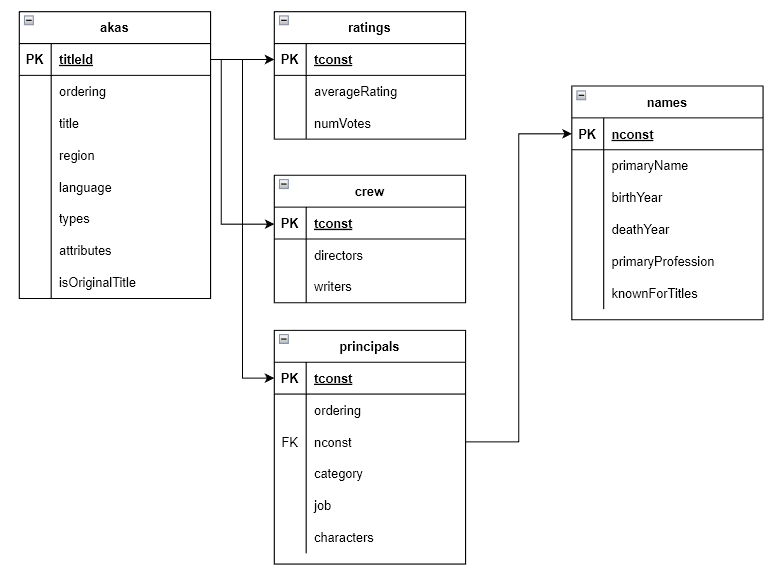

### 1)
Empezamos utilizando un conjunto de subqueries para devolver con un único comando SELECT la cantidad de filas en cada una de las tablas que tenemos para ir familiarizandonos con nuestros datos.


```sql
SELECT (SELECT COUNT(*) FROM bootcamp.akas) as "Count AKAs",
            (SELECT COUNT(*) FROM bootcamp.ratings) as "Count Ratings",
            (SELECT COUNT(*) FROM bootcamp.names) as "Count Names",
            (SELECT COUNT(*) FROM bootcamp.principals) as "Count Principals",
            (SELECT COUNT(*) FROM bootcamp.crew) as "Count Crew")
```



In [ ]:
%sql SELECT (SELECT COUNT(*) FROM bootcamp.akas) as "Count AKAs", (SELECT COUNT(*) FROM bootcamp.ratings) as "Count Ratings", (SELECT COUNT(*) FROM bootcamp.names) as "Count Names", (SELECT COUNT(*) FROM bootcamp.principals) as "Count Principals", (SELECT COUNT(*) FROM bootcamp.crew) as "Count Crew"

 * postgresql+psycopg2://@/postgres


,Count AKAs,Count Ratings,Count Names,Count Principals,Count Crew
0,200000,200000,200000,200000,200000


### 2)
Supongamos ahora el siguiente caso:

Nos solicitan retornar aquellas peliculas que tengan un rating superior al rating promedio.

Nuevamente, podemos obtener esto con usando un subquery



```sql
SELECT *
FROM bootcamp.ratings
WHERE averagerating > (SELECT AVG(averagerating) FROM bootcamp.ratings)
```



In [ ]:
%sql SELECT * FROM bootcamp.ratings WHERE averagerating > (SELECT AVG(averagerating) FROM bootcamp.ratings)

 * postgresql+psycopg2://@/postgres


,index,tconst,averagerating,numvotes
0,2,tt0000003,6.5,1686
1,9,tt0000010,6.9,6835
2,11,tt0000012,7.4,11739
3,13,tt0000014,7.1,5259
4,39,tt0000041,6.8,1743
...,...,...,...,...
106645,199993,tt0347050,6.8,10
106646,199994,tt0347052,7.9,25
106647,199995,tt0347053,6.4,10
106648,199997,tt0347060,7.3,28


### 3)

Continuando con el ejercicio anterior, ahora nos solicitan que traigamos también los títulos y regiones de dichas películas.
Como ya vimos en la clase anterior, podemos obtener esto fácilmente utilizando un JOIN.
¿Pero que tipo de JOIN?

Resumamos lo que necesitamos:
- Traer las películas, cuyo rating es superior al promedio - 'bootcamp.ratings'
- Agregarle información de la tabla 'bootcamp.akas' en caso exista.
- Sabemos además que, por fuera del titulo, no precisaríamos más datos de la tabla 'bootcamp.akas'

A priori pareciera ser que un LEFT JOIN cumpliría con todos los requisitos.

Probemos lo siguiente:



```sql
SELECT r.tconst "R_Title_ID",
       r.averagerating "R_Rating",
       r.numvotes "R_Numero_de_votos",
       a.title "A_Titulo",
       a.region "A_Region"
FROM bootcamp.ratings r
LEFT JOIN bootcamp.akas a
ON r.tconst = a.titleid
WHERE r.averagerating > (SELECT AVG(averagerating) FROM bootcamp.ratings)
```



In [ ]:
%sql SELECT r.tconst "R_Title_ID",r.averagerating "R_Rating",r.numvotes "R_Numero_de_votos",a.title "A_Titulo",a.region "A_Region" FROM bootcamp.ratings r LEFT JOIN bootcamp.akas a ON r.tconst = a.titleid WHERE r.averagerating > (SELECT AVG(averagerating) FROM bootcamp.ratings)

 * postgresql+psycopg2://@/postgres


,R_Title_ID,R_Rating,R_Numero_de_votos,A_Titulo,A_Region
0,tt0000014,7.1,5259,O Regador Regado,BR
1,tt0000014,7.1,5259,The Sprayer Sprayed,US
2,tt0000014,7.1,5259,L'arroseur arrosé,FR
3,tt0000014,7.1,5259,L'arroseur arrosé,\N
4,tt0000014,7.1,5259,Заливена вода,RS
...,...,...,...,...,...
184847,tt0061415,7.2,44,None,None
184848,tt0308599,6.7,21,None,None
184849,tt0237036,8.0,87,None,None
184850,tt0175884,7.0,18,None,None


### 3)bis
¿Qué sucede si nos confundimos el tipo de JOIN?

La realidad es que no pasa nada, simplemente no obtendremos el resultado que queremos ya sea porque filtramos datos de más - o de menos - pero no es que el motor vaya a arrojar ningún error. Por esto es muy importante que revisemos y analicemos si los resultados obtenidos son consistentes con lo que necesitamos.

Como ejemplo, ejecutemos la misma query del ejercicio anterior cambiando el LEFT JOIN por otro tipo de JOIN y veamos cual es el resultado.

```sql
SELECT r.tconst "R_Title_ID",
       r.averagerating "R_Rating",
       r.numvotes "R_Numero_de_votos",
       a.title "A_Titulo",
       a.region "A_Region"
FROM bootcamp.ratings r
INNER JOIN bootcamp.akas a
ON r.tconst = a.titleid
WHERE r.averagerating > (SELECT AVG(averagerating) FROM bootcamp.ratings)
```

In [ ]:
%sql SELECT r.tconst "R_Title_ID",r.averagerating "R_Rating",r.numvotes "R_Numero_de_votos",a.title "A_Titulo",a.region "A_Region" FROM bootcamp.ratings r RIGHT JOIN bootcamp.akas a ON r.tconst = a.titleid WHERE r.averagerating > (SELECT AVG(averagerating) FROM bootcamp.ratings)

 * postgresql+psycopg2://@/postgres


,R_Title_ID,R_Rating,R_Numero_de_votos,A_Titulo,A_Region
0,tt0000014,7.1,5259,O Regador Regado,BR
1,tt0000014,7.1,5259,The Sprayer Sprayed,US
2,tt0000014,7.1,5259,L'arroseur arrosé,FR
3,tt0000014,7.1,5259,L'arroseur arrosé,\N
4,tt0000014,7.1,5259,Заливена вода,RS
...,...,...,...,...,...
86855,tt0036171,6.6,46,Moonlight in Vermont,\N
86856,tt0036171,6.6,46,Inquietude Primaveril,BR
86857,tt0036171,6.6,46,Roseiral Florido,PT
86858,tt0036171,6.6,46,Inquietud primaveral,MX


### 4)
Inmediatamente después, nos comentan que ésta data la necesitarían disponible por separado y que, idealmente, el usuario final no se deba preocupar por escribir correctamente los JOINS, las subqueries ni nada por el estilo.

Podemos crear una vista para hacerlo!



```sql
CREATE OR REPLACE VIEW pelis_buenas_con_titulo AS
SELECT * 
FROM bootcamp.ratings r
LEFT JOIN bootcamp.akas a
ON r.tconst = a.titleid
WHERE r.averagerating > (SELECT AVG(averagerating) FROM bootcamp.ratings)
```
Observación: Agregamos un LIMIT 1000 al final para no sobrecargar la base.


In [ ]:
%sql CREATE OR REPLACE VIEW pelis_buenas_con_titulo AS SELECT r.*, a.title FROM bootcamp.ratings r LEFT JOIN bootcamp.akas a ON r.tconst = a.titleid WHERE r.averagerating > (SELECT AVG(averagerating) FROM bootcamp.ratings) LIMIT 1000;

 * postgresql+psycopg2://@/postgres


""


### 5)
Como comentamos en la clase teórica, ahora nuestra vista existe como "una tabla virtual" a la que podemos consultar de la misma manera que lo haríamos con una tabla real.

Por ejemplo:



```sql
SELECT COUNT(*)
FROM pelis_buenas_con_titulo
```

O bien:



```sql
SELECT MAX(numvotes)
FROM pelis_buenas_con_titulo
```




In [ ]:
%sql SELECT COUNT(*) FROM pelis_buenas_con_titulo

 * postgresql+psycopg2://@/postgres


,count
0,1000


In [ ]:
%sql SELECT MAX(numvotes) FROM pelis_buenas_con_titulo

 * postgresql+psycopg2://@/postgres


,max
0,19083


### 6) 
Probemos algo un tanto más complejo.

Supongamos que nos solicitan lo siguiente:
- El titulo de la película
- Con el numero de votos máximo
- Con las condiciones de:
  - Que haya un actor con "John" en su nombre
  - Y cuyo actor tenga menos de 75 años

Para poder cumplir con ésto vamos a tener que conocer bien en detalle nuestro modelo de datos - es decir las tablas y los datos que viven en ellas.

```sql
SELECT a.title, CAST(r.numvotes AS INTEGER)
FROM bootcamp.names n 
LEFT JOIN bootcamp.principals p 
ON n.nconst = p.nconst 

LEFT JOIN bootcamp.ratings r 
ON p.tconst = r.tconst 

LEFT JOIN bootcamp.akas a 
ON p.tconst = a.titleid 

WHERE n.birthyear NOT LIKE '%N%' 
AND CAST(date_part('year', NOW()) AS INTEGER) - CAST(n.birthyear AS INTEGER) < 75 
AND n.primaryname LIKE '%John%' 
AND r.numvotes IS NOT NULL 

ORDER BY 2 DESC 
LIMIT 1;
```






In [ ]:
%sql SELECT a.title, CAST(r.numvotes AS INTEGER) FROM bootcamp.names n LEFT JOIN bootcamp.principals p ON n.nconst = p.nconst LEFT JOIN bootcamp.ratings r ON p.tconst = r.tconst LEFT JOIN bootcamp.akas a ON p.tconst = a.titleid WHERE n.birthyear NOT LIKE '%N%' AND CAST(date_part('year', NOW()) AS INTEGER) - CAST(n.birthyear AS INTEGER) < 75 AND n.primaryname LIKE '%John%' AND r.numvotes IS NOT NULL ORDER BY 2 DESC LIMIT 1;

 * postgresql+psycopg2://@/postgres


,title,numvotes
0,Shooting Stars,425




---



---



---



## Más Ejercicios:

1) Normalización:
Algunas de las tablas de nuestra base NO cumplen con al menos 1 de las formas normales:
  - Analizar cuales son
  - Que reglas o normas rompen
  - Sugerir una posible solución



2) TO-DOs:
  1. Retornar el actor con mayor numero de apariciones en películas
  2. Retornar el puesto de trabajo menos común
  3. Devolver el titulo más largo de una película incluyendo:
    - El rating
    - La cantidad de votos
  4. Crear una vista que contenga:
    - Las 10 películas con menor rating
    - Incluyendo titulo

In [ ]:
%sql SELECT * FROM bootcamp.principals LIMIT 10;